# Spotify Recommender Model

This notebook will explore making recommendations based on the vectorization of songs.  Using Word2Vec, a variety of different recommender model options are explored.  

1. **Content-Based**
> Predicts based on what a user has listened to in the past.
> Uses features of songs to find similar songs.

2. **Collaborative**
> Predicts based on what other listeners like
> Focuses on what songs other users liked who also liked a chosen song. 

2 collaborative-based approaches are presented in this notebook as well as 2 content-based models.

## Word2Vec
Word2Vec is a library that will create a vector space.  As its name implies, Word2Vec was originally intended to convert Words to Vectors.  Here, we will use that intended functionality to convert Songs to Vectors.  

### Embeddings
Word2Vec is a process that uses vectorized words to predict other words.  It does this by ingesting a series of documents, parsing out the words, vectorizing the words and then using the vector representations to predict other words.  The vectors are built in such a way that each word has a unique vector that is based on its usage in the documents.  The result is a vector space filled with words where related words have vectors that are similar.  This vector space is referred to an an **embedding**.  This embedding is used in two common word prediction tasks: `Skip-Gram` and `Continuous Bag of Words`.

> **Skip-Gram** <br>
> The Skip-Gram model attempt to find words that surround a given word or set of words.

> **Bag-of-Words** <br>
> The bag-of-words model asks for a series of words and will return words that appear to be missing from the provided context.

<a name='metrics'></a>
### Metrics
<a href=#r-prec>R-precision</a> and <a href=#ndgc>Normialzed Discounted Cumulative Gain (NDGC)</a> are used as metrics.  Methods are included below that calculate these metrics.  In order to test a model, 100 playlists are passed through each metric and a mean of the results is returned.


### Making a Playlist
What does this have to do with playlists?  Good question.  If we can consider a Song as a Word and a Playlist as a document, the applicability is more evident.

To make a playlist, we simply convert Songs to Vectors and then find new songs by finding other songs with similar vectors.  To schieve this, we can use the Bag-of-Words or Skip-Gram approach as mentioned above.  

Various approaches using these concepts are explored below:

<a name='index'></a>
### <a href=#1>1. Embeddings from Playlists - Content-Based</a>
> Here, we will take data from Spotify that included 1M playlists and the songs in each playlist.  We'll use the Word2Vec process supplying playlists as documents and each song's unique id is used as the word. <br><br>
Word2Vec will create an embedding of song vectors that can subsequently be used to create a Skip-Gram or Bag-of_words model; however, in this first approach, we will simply use the embeddings to find a playlist. <br><br>This approach is unsupervised.  No process is used to 'guide' the model into determining if it's output is correct or not.

### <a href=#2>2. Bag-of-Words Model - Collaborative</a>
> In this approach, we will use the embedding used above to train a Bag-of-Words model to create a recommended playlist.  Unlike the first approach, this model is supervised and requires a training process.


### <a href=#3>3. Skip-Gram Model - Collaborative</a>
> Using the same embedding as before, we will train a Skip-Gram model to create recommendations.  Like the Bag-of_words model, Skip-Gram is a supervised model and will require a training process.


### <a href=#4>4. Song Features Embedding - 'Home-Made Vectors' - Content-Based</a>
> Here, we can take a break from Word2Vec and get very basic.  We create our own vectors based on Spotify accoustive feature data.  We have a series of fields available for all of our songs that numerically represent various characteristics of the songs; dancebaility, loudness, temp, key, energy, etc.  We can create vectors for each song based on these values and cast them into the Word2Vec format so that we can exploit some of the Word2Vec functionality. <br><br> Like our first model, this approach is unsupervised.  The model will be built without any feedback on whether is is achieving a certain result or not.



<br>

**References:**

https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/

https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484

https://towardsdatascience.com/how-to-build-a-simple-song-recommender-296fcbc8c85



### Import libraries

In [1]:
# Basic Imports
import warnings;
warnings.filterwarnings('ignore')

import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import normalize, Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from gensim.models import Word2Vec
from gensim import utils
import gensim.models
from gensim.models import KeyedVectors

# For the Spotify Dataset
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Table, Column, Integer, String, Float, MetaData, and_, or_, func
from sqlalchemy import create_engine
import sqlite3
from sqlalchemy.orm import sessionmaker
from sqlalchemy import exc

from sklearn.model_selection import train_test_split

sys.path.append('../../')
from spotify_api import get_spotify_data, get_tracks, get_artists, get_audiofeatures
from spotify_database import get_session, display_time
from spotify_utils import Table_Generator, List_Generator, pickle_load, pickle_save

# !pip install ipywidgets 
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

# %%capture
from tqdm import tqdm_notebook as tqdm


## Metrics
Before creating any playlists, let's setup some metrics so that we can evaluate our models.

<a name='r-prec'></a>
### R-Precision
<a href=#metrics>back to index</a>

Compares the a recommended list to a ground truth list.  This metric will simply calculate the percentage of tracks that match a ground truth.

We can compare the intersection of tracks and the intersection of artists.

let: <br>
> $G$ = ground truth (validation playlist) <br>
> $R$ = recommendation list<br>

> $R-precision = \frac{|G \bigcap R_{1:|G|}|}{|G|}$


In [2]:
def calc_rPrecision(ground_truth, recommendation)->float:
    """
    Calculates r-precision based on a list of ground truth 
    items and a list of recommended items.
    Each argument is a list of items to compare.
    """
    G=set(ground_truth)
    R=set(recommendation)
    
    return len(G&R)/len(G)

<a name='ndgc'></a>
### NDCG - Normalized Discounted Cumulative Gain
<a href=#metrics>back to index</a>

NDCG will incorporate not only the relevance, but also the order of the items in the recommended playlist.

To caluclate, we need the the DCG (discounted cumulative gain)  which measures the ranking quality.  We also need the IDCG (ideal discounted cumulative gain).

> $DCG = rel_1 + \sum^{|R|}_{i=2}\frac{rel_i}{log_2(i+1)} $ <br>
> $IDCG = 1 + \sum^{|G|}_{i=2}\frac{1}{log_2(i+1)} $

NDGC is calculated as follows: <br>
> $NDCG=\frac{DCG}{IDCG}$

Where $rel_{{i}}$ is the graded relevance of the result at position $i$.  Relevance = 1 when the recommended track is in the ground truth playlist.

In [3]:
def calc_track_NDCG(ground_truth, recommendation)->float:
    list_len = len(recommendation)
    scores = [(track in recommendation) for track in ground_truth[0:list_len]]
    
    DCG  = scores[0] + np.sum(scores[1:]/np.log2( np.arange(1,list_len)+1) )
    IDCG = 1 + np.sum(1/np.log2( np.arange(1,list_len)+1 ))
    NDGC = DCG/IDCG
    
    return NDGC

In [4]:
def calc_track_metrics(ground_truth, recommendation, display=True)-> (float,float):
    """
    Prints relevant metrics give a grount truth playlist and a 
    recommended playlist.
    """
    r_prec = calc_rPrecision(ground_truth, recommendation)
    NDGC = calc_track_NDCG(ground_truth, recommendation)
    
    if display:
        print("Track R-Precision: {}".format(r_prec))
        print("Track NDGC       : {}".format(NDGC))
    
    return r_prec, NDGC

In [35]:
def eval_model(model, df_withheld, df_given, display=True, num_test:int=10, name:str=None) -> (float,float):
    """
    Will perform an r_precision and NDCG calculation on a
    restricted set of test playlists and return a mean of each score
    for all scored playlists.
    """
    r_precs_tracks = []
    r_precs_artists = []
    NDCGs = []
    lengths = []
    playlists = np.unique(df_given.playlist_id.values)
    playlists = np.random.choice(playlists, size=num_test)
    
    for plistID in tqdm(playlists, desc="calculating metrics"):
        df_seed_tracks = df_given[df_given.playlist_id.isin([plistID])]
        seed_uris = df_seed_tracks.track_uri.values
        
        try:
            # for embedding, use the first track as the seed
            if type(model) == gensim.models.keyedvectors.Word2VecKeyedVectors:
                playlist_rec = np.array(embedding.similar_by_word(seed_uris[0], 
                                                              topn=10))

            elif type(model) == gensim.models.word2vec.Word2Vec:
                playlist_rec = np.array(BOW_model.predict_output_word(seed_uris, 
                                                                      topn=10))

            withheld_uris = df_withheld[df_withheld.playlist_id.isin([plistID])].track_uri.values

            r_prec_track, NDGC = calc_track_metrics(withheld_uris, 
                                                    playlist_rec[:,0],
                                                    display=False)
            
            
            
            # calculate artist r-precision
            withheld_artist_uris = np.unique(df_withheld[df_withheld.playlist_id.isin([plistID])].artist_uri.values)

            # get artists from playlist tracks
            playlist_artists = np.unique(df_playlists_train[df_playlists_train.track_uri.isin(playlist_rec[:,0])]['artist_uri'].values)

            r_prec_artist = calc_rPrecision(withheld_artist_uris, playlist_artists)
            
            r_precs_artists.append(r_prec_artist)
            r_precs_tracks.append(r_prec_track)
            NDCGs.append(NDGC)
            lengths.append(len(df_seed_tracks)+10)
            
        except:
            continue
    
    if display:
        print("Mean Track R-Precision : {}".format(np.mean(r_precs_tracks)))
        print("Mean Artist R-Precision: {}".format(np.mean(r_precs_artists)))
        print("Mean Track NDGC        : {}".format(np.mean(NDCGs)))
        
        fig, ax = plt.subplots(ncols=3, figsize=(12,4))
        fig.suptitle("{} - Metrics".format(name, fontsize=16))
        fig.tight_layout(pad=4)

        sns.distplot(r_precs_tracks, kde=False, ax=ax[0])
        ax[0].set_title("R-Precision Track Scores")
        ax[0].set_xlabel("Score")
        ax[0].set_ylabel("Count")
        ax[0].set_xlim(0,1)
        
        sns.distplot(r_precs_artists, kde=False, ax=ax[1])
        ax[1].set_title("R-Precision Artist Scores")
        ax[1].set_xlim(0,1)

        sns.distplot(NDCGs, kde=False, ax=ax[2])
        ax[2].set_title("NDGC Scores")
        ax[2].set_xlim(0,1)
        fig.show()
        
    return r_precs_tracks, r_precs_artists, NDCGs
        
    

### Setup a Metrics DataFrame to collect results

In [31]:
df_metrics = pd.DataFrame(columns=['Artist_Rprec','Track_Rprec','NDGC'])

### Set Data Path Variables

In [7]:
data_path = '../../data/SpotifyDataSet'
db_path = '../../data/SpotifyDataSet/spotify_songs.db'

# Get sesion
session = get_session(db_path)
engine = create_engine('sqlite:///' + db_path)

# Get Songs class
Playlists = getattr(get_session, "Playlists")
Artists = getattr(get_session, "Artists")
Tracks = getattr(get_session, "Tracks")

In [8]:
# takes 5 minutes
df_playlists_test_withheld = pd.read_csv(os.path.join(data_path, "df_playlists_test_withheld.csv"), index_col='index')#.drop('Unnamed: 0', axis=1)
df_playlists_test_given    = pd.read_csv(os.path.join(data_path, "df_playlists_test_given.csv"), index_col='index')#.drop('Unnamed: 0', axis=1)
df_playlists_train         = pd.read_csv(os.path.join(data_path, "df_playlists_train.csv"), index_col='index')# .drop('Unnamed: 0', axis=1)


In [9]:
df_playlists_train.head()

,playlist_id,track_uri,track_name,artist_uri,artist_name
index,,,,,
0,1,spotify:track:2d7LPtieXdIYzf7yHPooWd,Chasing Cars,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Sleeping At Last
1,1,spotify:track:0y4TKcc7p2H6P0GJlt01EI,Elephants,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Rachael Yamagata
2,1,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,That Home,spotify:artist:32ogthv0BdaSMPml02X9YB,The Cinematic Orchestra
3,1,spotify:track:54KFQB6N4pn926IUUYZGzK,To Build A Home,spotify:artist:32ogthv0BdaSMPml02X9YB,The Cinematic Orchestra
4,1,spotify:track:0NeJjNlprGfZpeX2LQuN6c,River,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,Leon Bridges


## Review the Given Set of Songs
For reference, let's look at the songs that will be used in our models to produce recommendations.  This will help us to determin if the recommendations are reasonable.

We will use the `df_playlists_test_given` and `df_playlists_test_withheld` dataframes to test the models.  The `given` dataframe inlcludes 10 tracks from each of 10,000 playlists.  Any playlist of 10 tracks should be used to predict the corresponding `withheld` tracks from each playlist.

In [10]:
# pick a random playlist
test_playlistIDs = np.unique(df_playlists_test_given.playlist_id.values)
test_playlist_ID = np.random.choice(test_playlistIDs, size=1)
test_playlist_ID

array([279484])

In [11]:
# define 'given' and 'withheld' portions of test set
test_given = df_playlists_test_given[df_playlists_test_given.playlist_id.isin(test_playlist_ID)].track_uri.values
test_withheld = df_playlists_test_withheld[df_playlists_test_withheld.playlist_id.isin(test_playlist_ID)]

In [12]:
def print_recommended_playlist(playlist:np.array, df_withheld:pd.DataFrame=None)->None:
    """
    Print a playlist recommendation. Display to terminal output.
    """
    
    if len(playlist)>50:
        playlist = playlist[0:50]
    
    note = ""
    match = np.zeros(len(playlist))
    if df_withheld is not None:
        note = "(* indicates a match)"
        for i, t in enumerate(playlist):
            if t in df_withheld.track_uri.values:
                match[i] = 1
        print ("{} tracks matches.".format(np.sum(match).astype(int)))
    
    sp_playlist = get_tracks(playlist)
    print("RECOMMENDED PLAYLIST {}".format(note))
    print("{:1}{:20}{:30}{:30}".format("","Artist","Track","URI"))
    for i, t in enumerate(sp_playlist):
        print("{0:1}{1:20}{2:30}{3:30}".format( "*" if match[i] else "", t['artists'][0]['name'],  t['name'], t['uri']))
        print(" {}".format("<no preview>" if t['preview_url']==None else t['preview_url']))
        print()

<a name='1'></a>
## 1. Embeddings from Playlists - Content-Based
<a href=#index>back to index</a>


The baseline model will use embeddings to find similarities between songs.  The embeddings are built from playlists, where the playlist serves as a sentence made up of songs.

Similarities between songs are determined by their cosine distance with other songs.

To speed up to building of the enbedding, an extract is made from the database which will serve as documents for the embedding.  Each 'sentence' is a playlist and each 'word' is a song in the playlist.

From the DB, the following view is created which is subseqntly extracted as a CSV file:<br>

`CREATE VIEW playlist_tracks_uris AS SELECT t.playlist_id, group_concat(t.track_uri, ' ')  FROM playlists t GROUP BY  t.playlist_id;`


In [13]:
# get playlists CSV file into DataFrame - take 5 minutes
corpus_file = 'playlist_tracks.csv'
corpus_filepath = os.path.join(data_path, corpus_file)

df_playlists = pd.read_csv(corpus_filepath, sep='\t', header=None)
df_playlists.columns = ["playlistID","tracks"]
df_playlists.set_index('playlistID', drop=True, inplace=True)
df_playlists.head()

,tracks
playlistID,
1,spotify:track:2d7LPtieXdIYzf7yHPooWd spotify:t...
2,spotify:track:5j9iuo3tMmQIfnEEQOOjxh spotify:t...
3,spotify:track:4HBVGSeSPpSZ1QmMBhEtqp spotify:t...
4,spotify:track:1f5AW15GV76mk8JNxaPJIx spotify:t...
5,spotify:track:4Sj3djQIFuaH3VICDN3uAA spotify:t...


In [14]:
# remove test playlists from corpus
# playlists_train = df_playlists[df_playlists.index.isin(np.unique(df_playlists_train.playlist_id))]
playlists_train = df_playlists

In [15]:
# Iterator that yields the songs for each playlist in a Dataframe
class Playlist_URIs_df(object):
    """
    Playlist generator that yileds the track uris in a playlist.
    Yields one playlist at a time.
    """
    def __init__(self,
                 dataframe:pd.DataFrame=None,
                 name:str=None,
                 iters:int=None):
        self.dataframe    = dataframe
        self.length       = len(dataframe)
        self.name         = name
        self.count        = 0
        self.iters        = iters
        print("Creating Playlist Track Listing Generator:")
        print("\tlength     : ", self.length)
    
    def __iter__(self):
        
        self.count += 1
        progbar = tqdm(total=self.length, desc="{}:{}/{}".format(self.name, self.count, self.iters+1))
        
        for plId, line in self.dataframe.itertuples():
            progbar.update(1)
            yield line.split(' ') # space-delimited tracks
            
        progbar.close()    

In [16]:
iters = 10
playlists_gen = Playlist_URIs_df(dataframe=playlists_train,
                                 name="Building Vectors",
                                 iters=iters) 

Creating Playlist Track Listing Generator:
	length     :  999001


### Build embedding and BOW model

In [17]:
# Build a gensim BOW model including a word embedding
model_BOW = gensim.models.Word2Vec(sentences=playlists_gen,
                               workers = 8,    # number of processors
                               sg = 0,         # 1=skip-gram, 0=CBOW
                               iter=iters      # training iterations - default=5
                              )

# save the model
model_filepath = os.path.join(data_path, 'playlists_BOW.model')
model_BOW.save(model_filepath)

# Save the embedding
kv_filepath = os.path.join(data_path, 'playlists.embedding')
model_BOW.wv.save(kv_filepath)

# about 5 minutes per iteration with 4 processors // 2 min per iteration with 8

### Build Skip-Gram Model

In [18]:
# Build a gensim Skip-Gram model including a word embedding
model_SG = gensim.models.Word2Vec(sentences=playlists_gen,
                               workers = 8,    # number of processors
                               sg = 1,         # 1=skip-gram, 0=CBOW
                               iter=iters      # training iterations - default=5
                              )

# save the model
model_filepath = os.path.join(data_path, 'playlists_SG.model')
model_SG.save(model_filepath)

# NOTE: No need to save the embedding again, it is the same as in the BOW model

# about 5 minutes per iteration with 4 processors // 2 min per iteration with 8

### Model Attributes
Now, we have created an embedding and an associated model which follows the BOW approach.

#### wv
> This object essentially contains the mapping between words and embeddings. It can be used directly to query the embeddings in various ways. 

#### vocabulary
> This object represents the vocabulary (sometimes called Dictionary in gensim) of the model. 

### Review the Embedding
Get 10 'words' from the embedding's vocabulary.

In [19]:
# reload saved embedding
kv_filepath = os.path.join(data_path, 'playlists.embedding')
embedding = KeyedVectors.load(kv_filepath, mmap='r')

In [20]:
# display list of random track along with a count of appearances
songids = list(embedding.wv.vocab.keys())
idxs_rnd = [random.randint(0,len(songids)) for x in range(10)]

for i in idxs_rnd:
    print("Track: {}".format(songids[i]))
    print("\t",embedding.wv.vocab[songids[i]])

Track: spotify:track:6I33dDuSLdCWq6oGIAe6Zw
	 Vocab(count:8, index:414081, sample_int:4294967296)
Track: spotify:track:3nUAdHFVainPQ6IzHl0NZY
	 Vocab(count:21, index:221960, sample_int:4294967296)
Track: spotify:track:3NIeBhR3VNNBZuIjaQcL10
	 Vocab(count:104, index:67702, sample_int:4294967296)
Track: spotify:track:6AGTsYXO0IcJuw0k2iCr6N
	 Vocab(count:37, index:146138, sample_int:4294967296)
Track: spotify:track:1STsNTVLkBfG7dHsphUXQo
	 Vocab(count:11, index:340213, sample_int:4294967296)
Track: spotify:track:2g2BXgRn0A780i96frfBif
	 Vocab(count:5, index:587552, sample_int:4294967296)
Track: spotify:track:7umUzOggE00eZPdO8dJ5pc
	 Vocab(count:152, index:50505, sample_int:4294967296)
Track: spotify:track:2ikcrdojaxposFOBkgNMJ0
	 Vocab(count:9, index:376468, sample_int:4294967296)
Track: spotify:track:1XeUMzRDmo9FEr3oVJ6krc
	 Vocab(count:60, index:102685, sample_int:4294967296)
Track: spotify:track:1jHvTHsAihdub9P4GPslfj
	 Vocab(count:6, index:494994, sample_int:4294967296)


### Display the Embedded Vector

In [21]:
# Show the vector value for the first word in in the list above
rnd = random.randint(0, len(embedding.wv.vocab))
print(songids[idxs_rnd[0]])
display(embedding.wv.get_vector(songids[idxs_rnd[0]]))

spotify:track:6I33dDuSLdCWq6oGIAe6Zw


memmap([-0.20194796, -0.0951275 , -0.16597189,  0.22197457, -0.16126293,
        -0.2913923 , -0.02122786,  0.07016449,  0.28847015, -0.16822931,
        -0.03475088, -0.17698812,  0.24477491, -0.10436277,  0.2570401 ,
         0.02260357, -0.16207422,  0.11874739, -0.05837788,  0.26608488,
        -0.04915364,  0.06113832,  0.1391742 ,  0.5031157 , -0.14630947,
         0.11567287,  0.250003  , -0.0318879 ,  0.02277716,  0.03602669,
        -0.40431356, -0.08674627,  0.04368311, -0.14785205,  0.01709409,
        -0.14679733,  0.09691612,  0.02004326,  0.1034709 , -0.16495632,
        -0.27236652, -0.25963262, -0.22802785, -0.04064661,  0.41573924,
         0.15141656,  0.26188433,  0.16129054, -0.21435815,  0.13651738,
         0.41101474,  0.0085716 , -0.05318414,  0.18670265, -0.06347857,
        -0.0589465 , -0.08657024, -0.41686288,  0.1219418 , -0.06854289,
         0.39836627,  0.3918365 , -0.16623805,  0.01100031, -0.1347017 ,
         0.44114256, -0.06169327, -0.09201338, -0.2

### Use the Word2Vec embedding to find similar songs based on single Song
Using the Word2Vec function `similar_by_word()`.  When using embeddings to predict a playlist, we are limited to inputting a single 'word' or song.

In [22]:
seed_uri = test_given[0]

In [23]:
# Find similar songs based on a single song
playlist_rec = np.array(embedding.similar_by_word(seed_uri, topn=10, restrict_vocab=None))

In [24]:
# Get the similar songs from Spotify to show their details, including preview link (if available)
sp_playlist = get_tracks(playlist_rec[:,0])
print("SEED TRACK")
sp_seed_track = get_tracks([seed_uri]) # get spotify data for track

print("Artist       : ",   sp_seed_track[0]['artists'][0]['name'])
print("Track        : ",   sp_seed_track[0]['name'])
print("Track Preview: \n", sp_seed_track[0]['preview_url'] )
print()

print_recommended_playlist(playlist_rec[:,0], test_withheld)


Setting credentials
token():INFO:   Getting initial token
token():INFO:   Token refreshed
SEED TRACK
Artist       :  Fleetwood Mac
Track        :  Second Hand News - 2004 Remaster
Track Preview: 
 https://p.scdn.co/mp3-preview/121c8c5edd1011d701a6783a9bf8ccdbf36c55da?cid=72413f75d4db4ec79c6caaf02523959e

0 tracks matches.
RECOMMENDED PLAYLIST (* indicates a match)
 Artist              Track                         URI                           
 Fleetwood Mac       I Don't Want to Know - 2004 Remasterspotify:track:6mGTiazKYI1BHT2uc9wTUL
 https://p.scdn.co/mp3-preview/dcccaa651849cd516864d37ae67560c4c13c2533?cid=72413f75d4db4ec79c6caaf02523959e

 Fleetwood Mac       Never Going Back Again - 2004 Remasterspotify:track:2TJqhMuTx2eMun7MMQVIFy
 https://p.scdn.co/mp3-preview/fe6cad3dd8ccd78bcdc8ee53be411b34d91dcd35?cid=72413f75d4db4ec79c6caaf02523959e

 Fleetwood Mac       Say You Love Me               spotify:track:6lrQo6KAYvb92MGk6ZuZlt
 https://p.scdn.co/mp3-preview/6bbb1e585f8a9559d9c26b

### Calculate Metrics

In [25]:
# Calculate the metrics on just this playlist
r_prec, NDCG = calc_track_metrics(test_withheld.track_uri.values, playlist_rec[:,0])

Track R-Precision: 0.0
Track NDGC       : 0.0



Mean Track R-Precision : 0.014583333333333332
Mean Artist R-Precision: 0.061594742063492074
Mean Track NDGC        : 0.012745254463360306


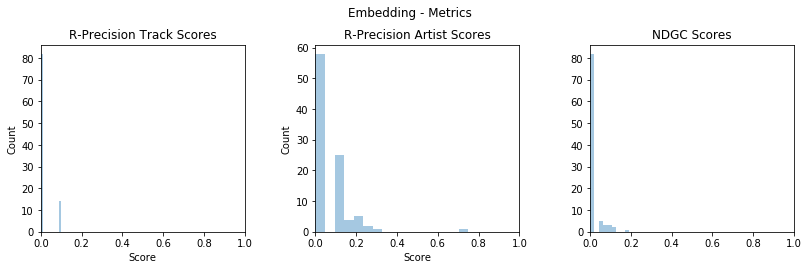

In [32]:
# calculate metrics on 100 playlists
r_precs_tracks, r_precs_artists, NDCGs = eval_model(embedding, df_playlists_test_withheld, df_playlists_test_given, num_test=100, name="Embedding")
df_metrics = df_metrics.append(pd.Series(name='Embedding', data=[np.mean(r_precs_artists), np.mean(r_precs_tracks), np.mean(NDCGs)], index=df_metrics.columns))


### Results:
Based on the playlists that were supplied when buidling the embedding, the list of Top 10 most similar songs is presented above.  The results don't score well; however, the recommended tracks seem like reasonable recommendations based on the seed track.

This playlist is based on the top songs that other users placed in playlists that include the song we selected as our seed.  This is a good example of 'collaborative filtering' as it uses preferences from others to recommend songs.

<a name='2'></a>
## 2. Embeddings from Playlists - Song ID - BOW
<a href=#index>back to index</a>

Now, let's use the model that was created when we initially established our embedding.  The BOW model can be used to predict a song from a song or a list of supplied songs.

The same seed playlist will be used as previously.

In [33]:
# Load the BOW model saved previously
model_filepath = os.path.join(data_path, 'playlists_BOW.model')
BOW_model = Word2Vec.load(model_filepath)

In [34]:
recommended_songs = np.array(BOW_model.predict_output_word(test_given, topn=10))
print_recommended_playlist(recommended_songs[:,0], test_withheld)


2 tracks matches.
RECOMMENDED PLAYLIST (* indicates a match)
 Artist              Track                         URI                           
*Fleetwood Mac       Go Your Own Way - 2004 Remasterspotify:track:07GvNcU1WdyZJq3XxP0kZa
 https://p.scdn.co/mp3-preview/b4b050fb5f906aba4e08064c453d3344ea68e583?cid=72413f75d4db4ec79c6caaf02523959e

 Stevie Nicks        Edge of Seventeen - 2016 Remasterspotify:track:7L3b6iaVhDVjfo52Hbvh9Z
 https://p.scdn.co/mp3-preview/8a7059e2f27a1d160f7e4844e479f887e5900cd2?cid=72413f75d4db4ec79c6caaf02523959e

 Fleetwood Mac       Don't Stop - 2004 Remaster    spotify:track:4bEb3KE4mSKlTFjtWJQBqO
 https://p.scdn.co/mp3-preview/e0b3d631102df852f2fa323eb92d2fe54c42f76c?cid=72413f75d4db4ec79c6caaf02523959e

 Fleetwood Mac       The Chain - 2004 Remaster     spotify:track:7Dm3dV3WPNdTgxoNY7YFnc
 https://p.scdn.co/mp3-preview/c75b9790ccb975d77c34f16fad5c20d2c0e97295?cid=72413f75d4db4ec79c6caaf02523959e

*Fleetwood Mac       Dreams - 2004 Remaster        spotify:tr

### Calculate Metrics


Mean Track R-Precision : 0.05222222222222221
Mean Artist R-Precision: 0.17568650793650797
Mean Track NDGC        : 0.04838845738576664


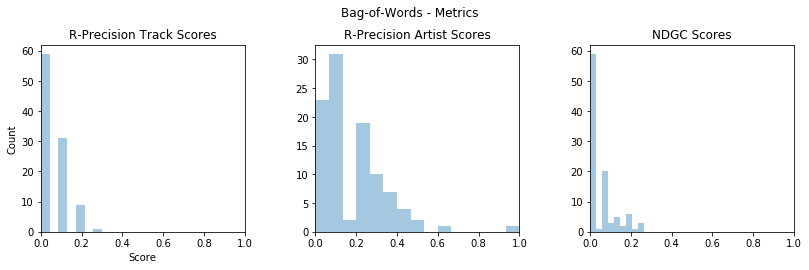

In [36]:
# r_precs, NDCGs = eval_model(BOW_model, df_playlists_test_withheld, df_playlists_test_given)
r_precs_tracks, r_precs_artists, NDCGs = eval_model(BOW_model, df_playlists_test_withheld, df_playlists_test_given, num_test=100, name="Bag-of-Words")
df_metrics = df_metrics.append(pd.Series(name='Bag_of_Words', data=[np.mean(r_precs_artists), np.mean(r_precs_tracks), np.mean(NDCGs)], index=df_metrics.columns))


### Result:
Only two songs matched the ground truth; however, the returned tracks look very reasonable given the inputs.

<a name='3'></a>
## 3. Embeddings from Playlists - Song ID - Skip-Gram
<a href=#index>back to index</a>

Here, we create a playlist from the Skip-Gram model.  For consistency, we will use the same song, "Free Fallin'", again to see if our results differ.

In [37]:
# load the skip-gram model we previously created
model_filepath = os.path.join(data_path, 'playlists_SG.model')
SG_model = Word2Vec.load(model_filepath)

In [38]:
recommended_songs = np.array(SG_model.predict_output_word([seed_uri], topn=10))
# sp_tracks = get_tracks(recommended_songs[:,0])

print_recommended_playlist(recommended_songs[:,0], test_withheld)


0 tracks matches.
RECOMMENDED PLAYLIST (* indicates a match)
 Artist              Track                         URI                           
 Fleetwood Mac       Second Hand News - 2004 Remasterspotify:track:0hlniElQOr5tvSKBaSpAQi
 https://p.scdn.co/mp3-preview/121c8c5edd1011d701a6783a9bf8ccdbf36c55da?cid=72413f75d4db4ec79c6caaf02523959e

 Fleetwood Mac       I Don't Want to Know - 2004 Remasterspotify:track:6mGTiazKYI1BHT2uc9wTUL
 https://p.scdn.co/mp3-preview/dcccaa651849cd516864d37ae67560c4c13c2533?cid=72413f75d4db4ec79c6caaf02523959e

 Fleetwood Mac       Never Going Back Again - 2004 Remasterspotify:track:2TJqhMuTx2eMun7MMQVIFy
 https://p.scdn.co/mp3-preview/fe6cad3dd8ccd78bcdc8ee53be411b34d91dcd35?cid=72413f75d4db4ec79c6caaf02523959e

 Fleetwood Mac       Monday Morning                spotify:track:0qjfjKFoP7LaqLI2KI9M1Q
 https://p.scdn.co/mp3-preview/28944fa16b01a0faaf693089efb5cb480bfaf4c8?cid=72413f75d4db4ec79c6caaf02523959e

 Fleetwood Mac       Don't Stop - 2004 Remaster  

### Calculate Metrics


Mean Track R-Precision : 0.041999999999999996
Mean Artist R-Precision: 0.14100396825396824
Mean Track NDGC        : 0.04750323649361899


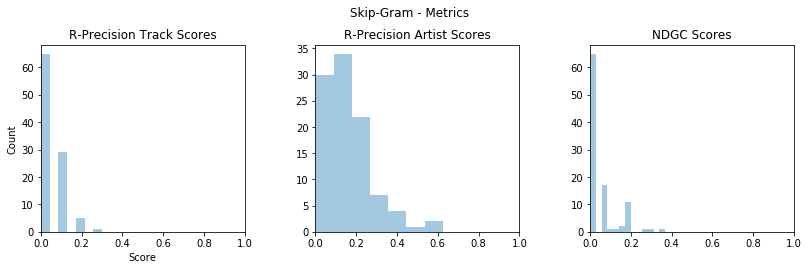

In [39]:
r_precs_tracks, r_precs_artists, NDCGs = eval_model(SG_model, df_playlists_test_withheld, df_playlists_test_given, num_test=100, name="Skip-Gram")
df_metrics = df_metrics.append(pd.Series(name='Skip_Gram', data=[np.mean(r_precs_artists), np.mean(r_precs_tracks), np.mean(NDCGs)], index=df_metrics.columns))


### Result:
Again, only one tracked matched producing a low evaluation result.  But like in the BOW model, the Skip-Gram model is producing song suggestions are are very much in line with the given set of tracks.

<a name='4'></a>
## 4. Embeddings from Song Features - Unsupervised
### 'Home-Made' Vectors
<a href=#index>back to index</a>

Here, we can take a break from Word2Vec and get very basic.  We create our own 'home-made' vectors based on Spotify accoustive feature data.  We have a series of fields available for all of our songs that numerically represent various characteristics of the songs; dancebaility, loudness, temp, key, energy, etc.

Instead of letter Word2Vec create an embedding, we create our own using these values.

In [40]:
# fetch all db tracks with accoustic features
db_tracks = display_time(session.query(Tracks).all)
session.close()

Time to Execute: 78.63 seconds


In [41]:
# create a Pandas dataframe
df_all_tracks = pd.DataFrame([x.__dict__ for x in db_tracks]).drop('_sa_instance_state', axis=1).set_index(['track_uri'])
df_all_tracks.head()

,artist_uri,track_popularity,duration_ms,valence,instrumentalness,acousticness,mode,key,danceability,time_signature,tempo,liveness,speechiness,loudness,energy
track_uri,,,,,,,,,,,,,,,
spotify:track:2d7LPtieXdIYzf7yHPooWd,spotify:artist:0MeLMJJcouYXCymQSHPn8g,65,242564,0.2770,0.000001,0.974,1,11,0.467,4,108.130,0.0816,0.0336,-9.649,0.157
spotify:track:0y4TKcc7p2H6P0GJlt01EI,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,36,253933,0.2780,0.008180,0.961,1,10,0.312,4,93.778,0.0773,0.0347,-13.367,0.207
spotify:track:6q4c1vPRZREh7nw3wG7Ixz,spotify:artist:32ogthv0BdaSMPml02X9YB,54,103920,0.0389,0.772000,0.991,1,9,0.412,4,85.462,0.0830,0.0278,-14.214,0.159
spotify:track:54KFQB6N4pn926IUUYZGzK,spotify:artist:32ogthv0BdaSMPml02X9YB,72,371320,0.0735,0.349000,0.885,1,9,0.264,4,148.658,0.0940,0.0349,-15.399,0.122
spotify:track:0NeJjNlprGfZpeX2LQuN6c,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,75,238560,0.1910,0.000000,0.689,1,8,0.658,4,128.128,0.1700,0.0448,-10.866,0.179


In [42]:
# define features that we will use to create our custom vectors
vector_features= [
    'acousticness',
    'danceability',
    'duration_ms',
    'energy',
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'speechiness',
    'tempo',
    'time_signature',
    'valence'
]

In [43]:
# Create a dataframe with the vectors for simplicity
drop_cols = set(df_all_tracks.columns) - set(vector_features)
df = df_all_tracks.drop(drop_cols, axis=1)
df.head()

,duration_ms,valence,instrumentalness,acousticness,mode,key,danceability,time_signature,tempo,liveness,speechiness,loudness,energy
track_uri,,,,,,,,,,,,,
spotify:track:2d7LPtieXdIYzf7yHPooWd,242564,0.2770,0.000001,0.974,1,11,0.467,4,108.130,0.0816,0.0336,-9.649,0.157
spotify:track:0y4TKcc7p2H6P0GJlt01EI,253933,0.2780,0.008180,0.961,1,10,0.312,4,93.778,0.0773,0.0347,-13.367,0.207
spotify:track:6q4c1vPRZREh7nw3wG7Ixz,103920,0.0389,0.772000,0.991,1,9,0.412,4,85.462,0.0830,0.0278,-14.214,0.159
spotify:track:54KFQB6N4pn926IUUYZGzK,371320,0.0735,0.349000,0.885,1,9,0.264,4,148.658,0.0940,0.0349,-15.399,0.122
spotify:track:0NeJjNlprGfZpeX2LQuN6c,238560,0.1910,0.000000,0.689,1,8,0.658,4,128.128,0.1700,0.0448,-10.866,0.179


### Normalize Data
The values will need to be normalized to avoid placing greater importance on predictors that have naturally larger values.

In [44]:
df.columns

Index(['duration_ms', 'valence', 'instrumentalness', 'acousticness', 'mode',
       'key', 'danceability', 'time_signature', 'tempo', 'liveness',
       'speechiness', 'loudness', 'energy'],
      dtype='object')

In [45]:
for col in df.columns:
    data = np.array(df[col]).reshape(-1,1)
    scaled_data = MinMaxScaler(feature_range=(0,1)).fit(data).transform(data)
    df[col] = scaled_data

In [46]:
# Confirm scaling is reasonable
df[vector_features].head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
track_uri,,,,,,,,,,,,,
spotify:track:2d7LPtieXdIYzf7yHPooWd,0.977912,0.468876,0.039950,0.157,0.000001,1.000000,0.0816,0.775549,1.0,0.034604,0.432542,0.8,0.2770
spotify:track:0y4TKcc7p2H6P0GJlt01EI,0.964859,0.313253,0.041830,0.207,0.008180,0.909091,0.0773,0.718282,1.0,0.035736,0.375132,0.8,0.2780
spotify:track:6q4c1vPRZREh7nw3wG7Ixz,0.994980,0.413655,0.017021,0.159,0.772000,0.818182,0.0830,0.705235,1.0,0.028630,0.341866,0.8,0.0389
spotify:track:54KFQB6N4pn926IUUYZGzK,0.888554,0.265060,0.061243,0.122,0.349000,0.818182,0.0940,0.686983,1.0,0.035942,0.594663,0.8,0.0735
spotify:track:0NeJjNlprGfZpeX2LQuN6c,0.691767,0.660643,0.039288,0.179,0.000000,0.727273,0.1700,0.756804,1.0,0.046138,0.512539,0.8,0.1910


### Convert 'home-made' Vectors into Word2Vec format
In order to exploit some of the Word2Vec built-in functionality, we can cast our vectors into a KeyedVectors object.  KeyedVectors is the Word2Vec object that hold all of the vectors in an embedded space.

In [47]:
# create a KeyedVectors object from the Word2Vec library
# This will allow us to use the built-in Word2Vec functions
accoustic_vectors = KeyedVectors(len(vector_features))

# weights are the vectors for each track
weights = np.array(df)

# entities are the trackuris
entities = np.array(df.index)

# add the vectors to the dataset
accoustic_vectors.add(entities, weights)

### How to calculate similarity
Here, we use Cosine similairity to determine recommended songs.  Cosine similarity will ignore the magnitude of a vector.  This is important in our usage.  Two completely different songs may have the exact same magnitude of the elements of the vector are similar in valud but in a different order.  Cosine similarity considers where each value is in a vector when making comparisons.

Cosine similairty is the default for Word2Vec.
(https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html#sphx-glr-auto-examples-core-run-similarity-queries-py)



In [48]:
# calculate recommendations based on 'home-made' vector
recommended_songs = np.array(accoustic_vectors.most_similar(df_playlists_test_given.track_uri.values, topn=10))[:,0]
print_recommended_playlist(recommended_songs, test_withheld)

0 tracks matches.
RECOMMENDED PLAYLIST (* indicates a match)
 Artist              Track                         URI                           
 Tommy Lee Sparta    Fi Get a 4Ward                spotify:track:5pXW9mNcfiy6Q0a3XnPvwR
 <no preview>

 Luscious Jackson    Hula Hoop                     spotify:track:2lhxvMG1gbH4gItZSFxe6W
 https://p.scdn.co/mp3-preview/a26555bb8b5abfeade1cf245aa823c0b93a730f4?cid=72413f75d4db4ec79c6caaf02523959e

 Kwesi Arthur        Grind Day                     spotify:track:1V3faphnJ5BVkflGrTlWf4
 https://p.scdn.co/mp3-preview/7c7317c7ac125e573e2b070b1237441c2b426e73?cid=72413f75d4db4ec79c6caaf02523959e

 J-Rio               Sors Ça                       spotify:track:27ECSowSIahjZVp3mTKQFU
 https://p.scdn.co/mp3-preview/d10fc955445868c2bd31dba385d85a36b3125bf0?cid=72413f75d4db4ec79c6caaf02523959e

 Joha                Shot for Me (La Contestacion) spotify:track:0LAewMyMUWcagznuGzzSVB
 <no preview>

 Khago               Me Blood Ah Boil              spotif

### Calculate Metrics


Mean Track R-Precision : 0.022446689113355782
Mean Artist R-Precision: 0.07281946448613115
Mean Track NDGC        : 0.022295739646974736


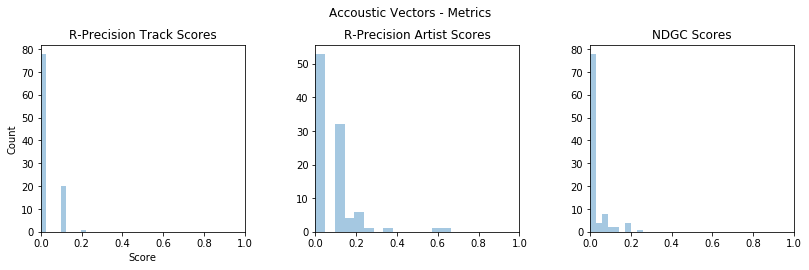

In [49]:
# r_precs, NDCGs = eval_model(accoustic_vectors, df_playlists_test_withheld, df_playlists_test_given)
r_precs_tracks, r_precs_artists, NDCGs = eval_model(accoustic_vectors, df_playlists_test_withheld, df_playlists_test_given, num_test=100, name="Accoustic Vectors")
df_metrics = df_metrics.append(pd.Series(name='Feature_Vectors', data=[np.mean(r_precs_artists), np.mean(r_precs_tracks), np.mean(NDCGs)], index=df_metrics.columns))


### Result:
This does not look so great (frankly, it is a disaster!).  The scores reflect this.  Not a single track was matched.  This list has nothing in common with our previous recommendations and the tracks selected are not similary to the seed playlist.  What happened?

This approach takes independent songs and creates vectors from the songs features.  These vectors have nothing to do with the playlists and have no other relationship to other vectors other than their cosine similarity.  If the cosine similarity defines a song then why doesn't this work?  We are overestimating our assumption that the accoustic vectors will determine a song.  We also don't account for the fact that some songs are missing features.  When a value is 0, it will have a significant impact on the calculated cosine similarity.

Our attempt with this approach was to create a 'content-based recommender' as described in the intoduction.  We are seeing that this is more challenging than expected.  

## Conclusion:
Implementation of a recommendation system using Word2Vec and embeddings is realtively simple.  Results are mixed.  Although none of the scores are strong, most of the model produced reasonable results based on subjective observation, but based on metrics, the results are not impressive.

The collaborative-models using supervised training performed best.  Considering that these models used over 66M songs during training, the 10 minute training time is relatively quick.  Inference was nearly immediate.  These collaborative-models will reflect popularity and present the user with a recommendation that mathces other users' tastes.  This can be seen as a benefit or a drawback.  These models will not provide the user with recommendations that are 'off the beaten path'.

The unsupervised, content-based approached explored above did not perform well.  The Word2Vec embedding producted subjectively reasonable results, but creating custom vectors without refernce to the playlists proved ineffective.  In order to implement this technique a carefully selected set of vectors is necessary.  This technique also requires all tracks to have a complete set of vector values in order to be effective.  In short, unsupervised recommendation methods require more detail to implement reasonably.


### Summary Metrics

In [50]:
df_metrics

,Artist_Rprec,Track_Rprec,NDGC
Embedding,0.061595,0.014583,0.012745
Bag_of_Words,0.175687,0.052222,0.048388
Skip_Gram,0.141004,0.042000,0.047503
Feature_Vectors,0.072819,0.022447,0.022296


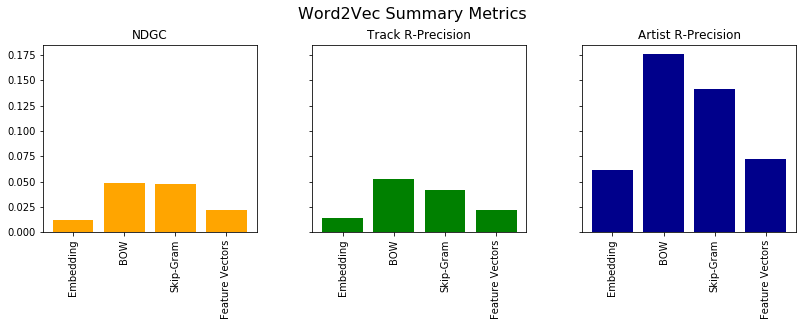

In [52]:
fig, ax = plt.subplots(figsize=(12,4), ncols=3, sharey=True)
fig.suptitle("Word2Vec Summary Metrics", fontsize=16)
fig.tight_layout(pad=4)

metrics = [df_metrics.NDGC, df_metrics.Track_Rprec, df_metrics.Artist_Rprec]
metrics_titles = ["NDGC", "Track R-Precision", "Artist R-Precision"]
colors = ['orange', 'g', 'darkblue']

for i, subplot in enumerate(ax.ravel()):
    subplot.bar(df_metrics.index, metrics[i], color=colors[i])
    subplot.set_xticklabels(labels=['Embedding','BOW', 'Skip-Gram', 'Feature Vectors'], rotation=90)
    subplot.set_title(metrics_titles[i])
